# Setup

## Imports

In [1]:
import QuantumToolbox as qt
using Logging
import CairoMakie as cm
using MiniLoggers
using Revise
using Dates

In [9]:
import SuperconductingCavities as SC

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


## Some Extra Stuff

In [10]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

MiniLogger{MiniLoggers.Squash, VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}, VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}, DateFormat{Symbol("yyyy-mm-dd HH:MM:SS"), Tuple{Dates.DatePart{'y'}, Dates.Delim{Char, 1}, Dates.DatePart{'m'}, Dates.Delim{Char, 1}, Dates.DatePart{'d'}, Dates.Delim{Char, 1}, Dates.DatePart{'H'}, Dates.Delim{Char, 1}, Dates.DatePart{'M'}, Dates.Delim{Char, 1}, Dates.DatePart{'S'}}}, typeof(string)}(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(19) open, 0 bytes waiting)), VSCodeServer.io_send_callback), VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Error, LogLevel(-1), Dict{Any, Int64}(), true, MiniLoggers.Token[MiniLoggers.Token("[", MiniLoggers

In [11]:
function tostr(obj)
    io = IOBuffer()
    show(io, "text/plain", obj)
    String(take!(io))
end

tostr (generic function with 1 method)

# Example

## Initializing Models

### Creating Model From Scratch

#### One Mode

In [5]:
Eᶜ = 0.10283303447280807;
Eʲ = 26.96976142643705;
Eᵒˢᶜ = 6.2280871213;
g = 0.026184375000000013;
name = "transmon";
ng  =  0;
N=10;
N_cut = 60;

OneMode = SC.Transmon_Resonators_Constructor(Eᶜ, Eʲ, [Eᵒˢᶜ], [g], N, [N], Cavity_Names = ["Mode 3"]);

#### Two Mode

In [6]:
Eᶜ = 0.10283303447280807;
Eʲ = 26.96976142643705;
Eᵒˢᶜs = [6.2280871213, 6.72062927579];
gs = [0.026184375000000013, 0.03020625000000001];
name = "transmon";
ng  =  0;
Nₜ =10;
Nᵣs = [6, 6]
N_cut = 60;


TwoModes = SC.Transmon_Resonators_Constructor(Eᶜ, Eʲ, Eᵒˢᶜs, gs, Nₜ, Nᵣs, Cavity_Names = ["Mode 3", "Mode 5"]);

### Importing Model

In [12]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");

In [13]:
Mode3.Stuff["op_drive_params"]["sb_f_0_4pi_f_3"]["Envelope Args"]

Dict{String, Any} with 3 entries:
  "pulse_time"   => 1601.37
  "sigma_factor" => 2
  "ramp_time"    => 10

In [14]:
Mode3.Stuff["Drive_Sequences"]

Dict{String, Any} with 1 entry:
  "Binomial_Encoding" => Any["q_e_0", "q_g_0", "sb_f_0_Main", "q_g_0", "q_e_1",…

## Time Evolving Wavefunctions

### Running A Single Pulse

In [22]:
ψ = Mode3.dressed_states[(0,0)]
res = SC.Dynamics.RunSingleOperator(Mode3, ψ, Mode3.Stuff["op_drive_params"]["q_g_0"], save_step = false, to_return = "All", step_name = "q_g_0", run_name = "Single_Op_Demo_"*string(now()));

[2024-10-03 13:15:25] Info: Running Time Evolution
Progress: [==================            ]  61.2% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 01s)

InterruptException: InterruptException:

You can directly plot the evolution using as in the cell below. however, it computes the overlaps every time. If you want to precompute those, view the cells after! 

[2024-10-03 11:55:22] Info: Making Plot


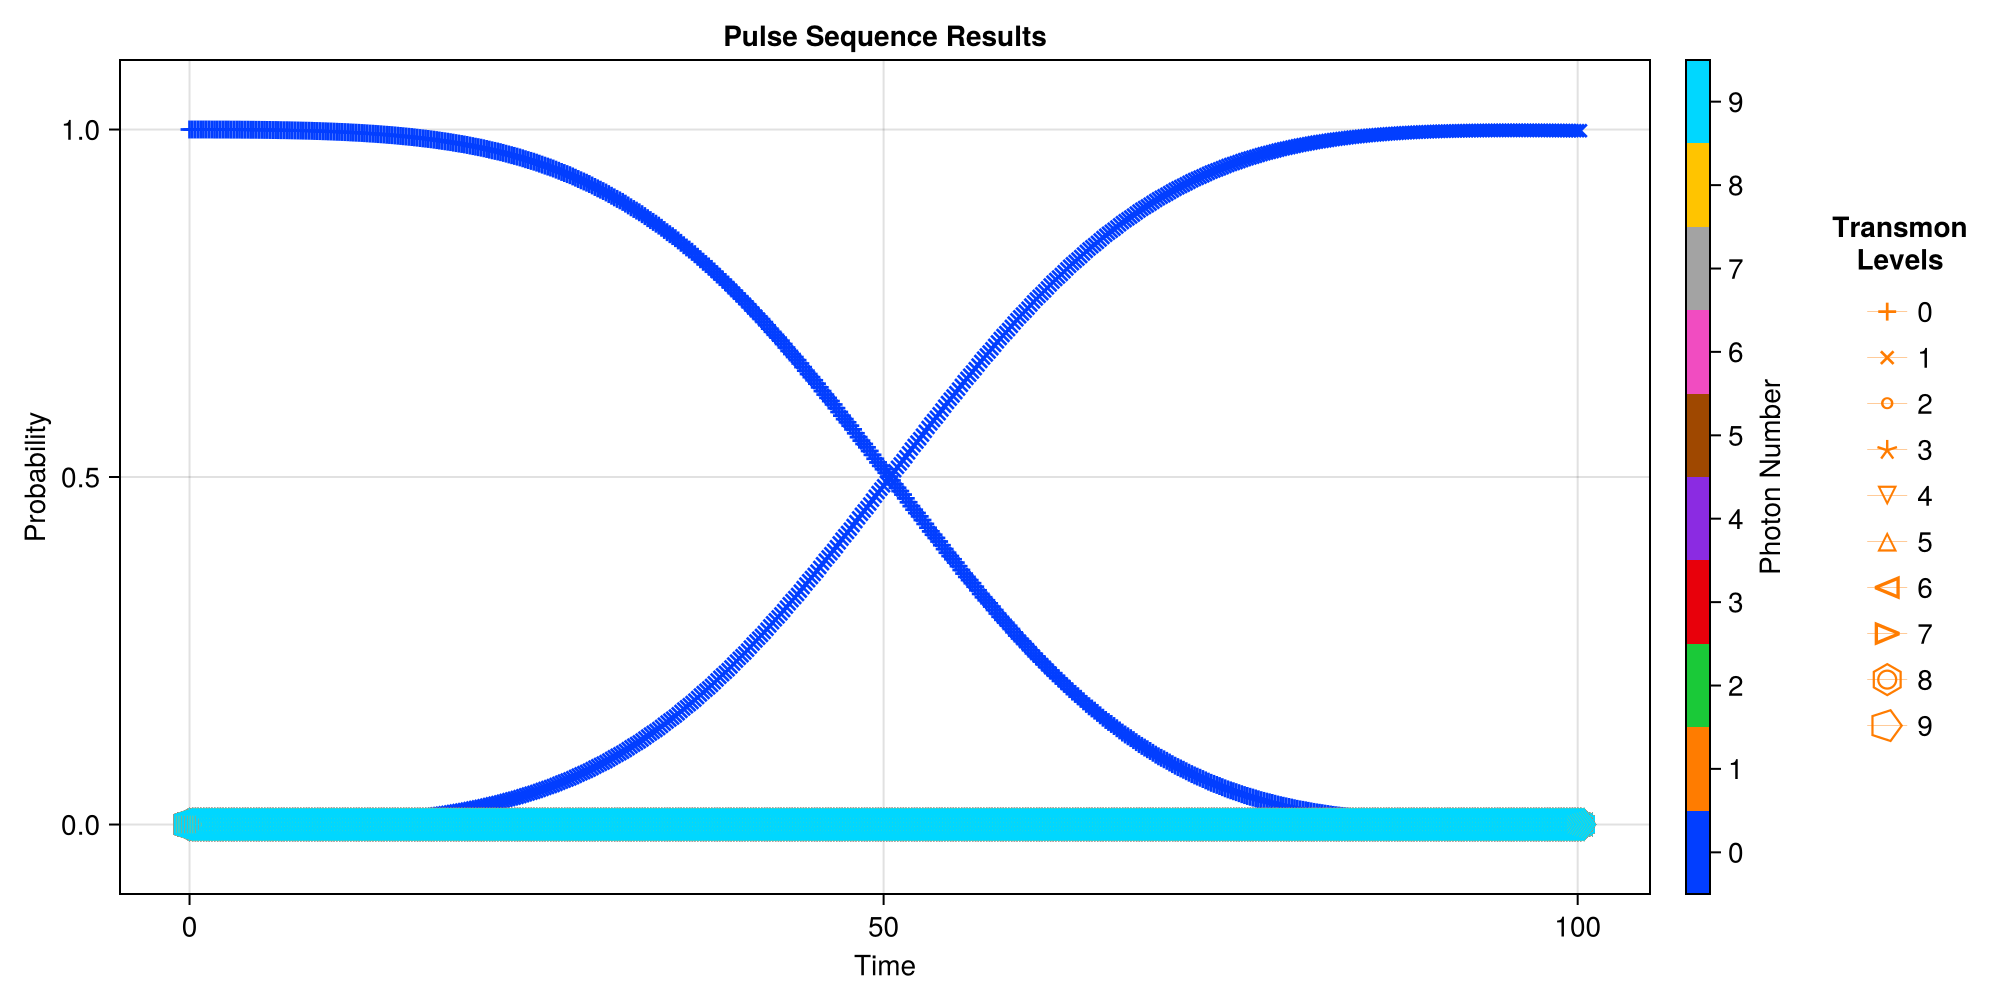

In [17]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, res.times, res.states)

In [16]:
# Takes in a dictionary of wave functions and gets a dictionary of projection operators
proj_dict = SC.Utils.Get_Projection_Ops(Mode3.dressed_states)

# Gets a dictionary of expectation values for a list of states. In this case the list of states
# is the state history and the op dict is the dict of projection ops
EV_Dict = SC.Utils.Get_EVs(res.states, proj_dict);



[2024-09-19 21:10:01] Info: Making Plot


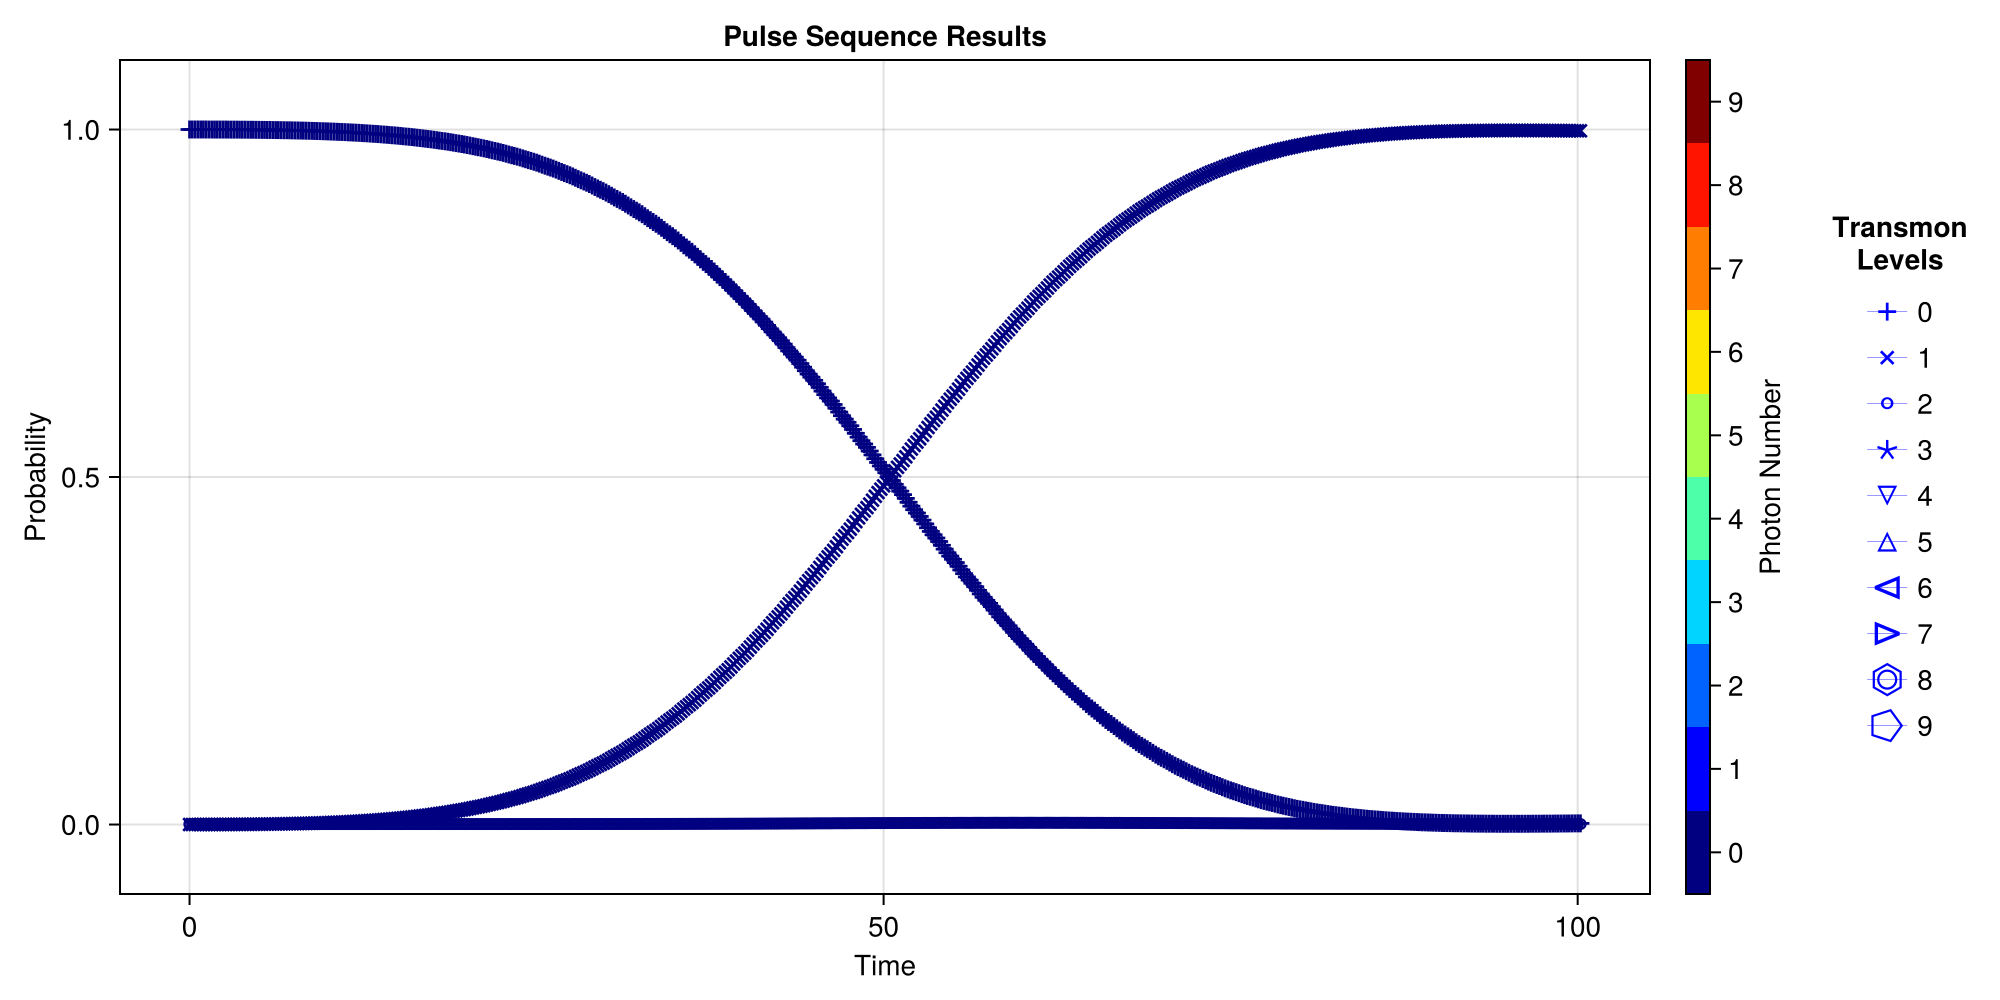

In [13]:
# Now to plot. Instead of passing in the list of states, we pass in the dictionary of all the expectation values

SC.PlotSingleModeEvolution(Mode3, res.times, EV_Dict)

### Running a Series of Operators

By default, RunPulesSequence does not return anything and stores data in a .nc file. You can have it return stuff by setting "Return = true" however that keeps the saved file. You can have it automatically delete the file by setting clean_up = true. Note, these two options are only there in the wavefunction version of the RunPulseSequence. If you pass in a density matrix then that function only writes and does not save. This is because instead of taking seconds, that function usually takes minutes to hours. 

#### Getting Data

In [15]:
ψ = Mode3.dressed_states[(0,0)]
#res = SC.RunPulseSequence(Mode3, ψ, ["q_g_0", "q_e_0"], Return = true, clean_up = true);
res = SC.Dynamics.RunPulseSequence(Mode3, ψ, Mode3.Stuff["Drive_Sequences"]["Binomial_Encoding"], Return = true, clean_up = true);

The Name for this run is: Operator_Sequence_2024-10-03T14:45:37.341
It is being saved at: Data/
[2024-10-03 14:45:37] Info: Running operator q_e_0
[2024-10-03 14:45:38] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-10-03 14:45:49] Info: Time Evolution Complete
[2024-10-03 14:45:49] Info: Saving Steps
[2024-10-03 14:46:00] Info: Done with Step_1
[2024-10-03 14:46:00] Info: Running operator q_g_0
[2024-10-03 14:46:00] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-10-03 14:46:04] Info: Time Evolution Complete
[2024-10-03 14:46:04] Info: Saving Steps
[2024-10-03 14:46:06] Info: Done with Step_2
[2024-10-03 14:46:06] Info: Running operator sb_f_0_Main
[2024-10-03 14:46:06] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-10-03 14:46:13] Inf

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


#### Making Plot

In [16]:
# Takes in a dictionary of wave functions and gets a dictionary of projection operators
proj_dict = SC.Utils.Get_Projection_Ops(Mode3.dressed_states);

# Gets a dictionary of expectation values for a list of states. In this case the list of states
# is the state history and the op dict is the dict of projection ops
EV_Dict = SC.Utils.Get_EVs(res["states"], proj_dict);


In [20]:
tuple([10,10]...)

(10, 10)

[2024-10-03 14:50:05] Info: Making Plot


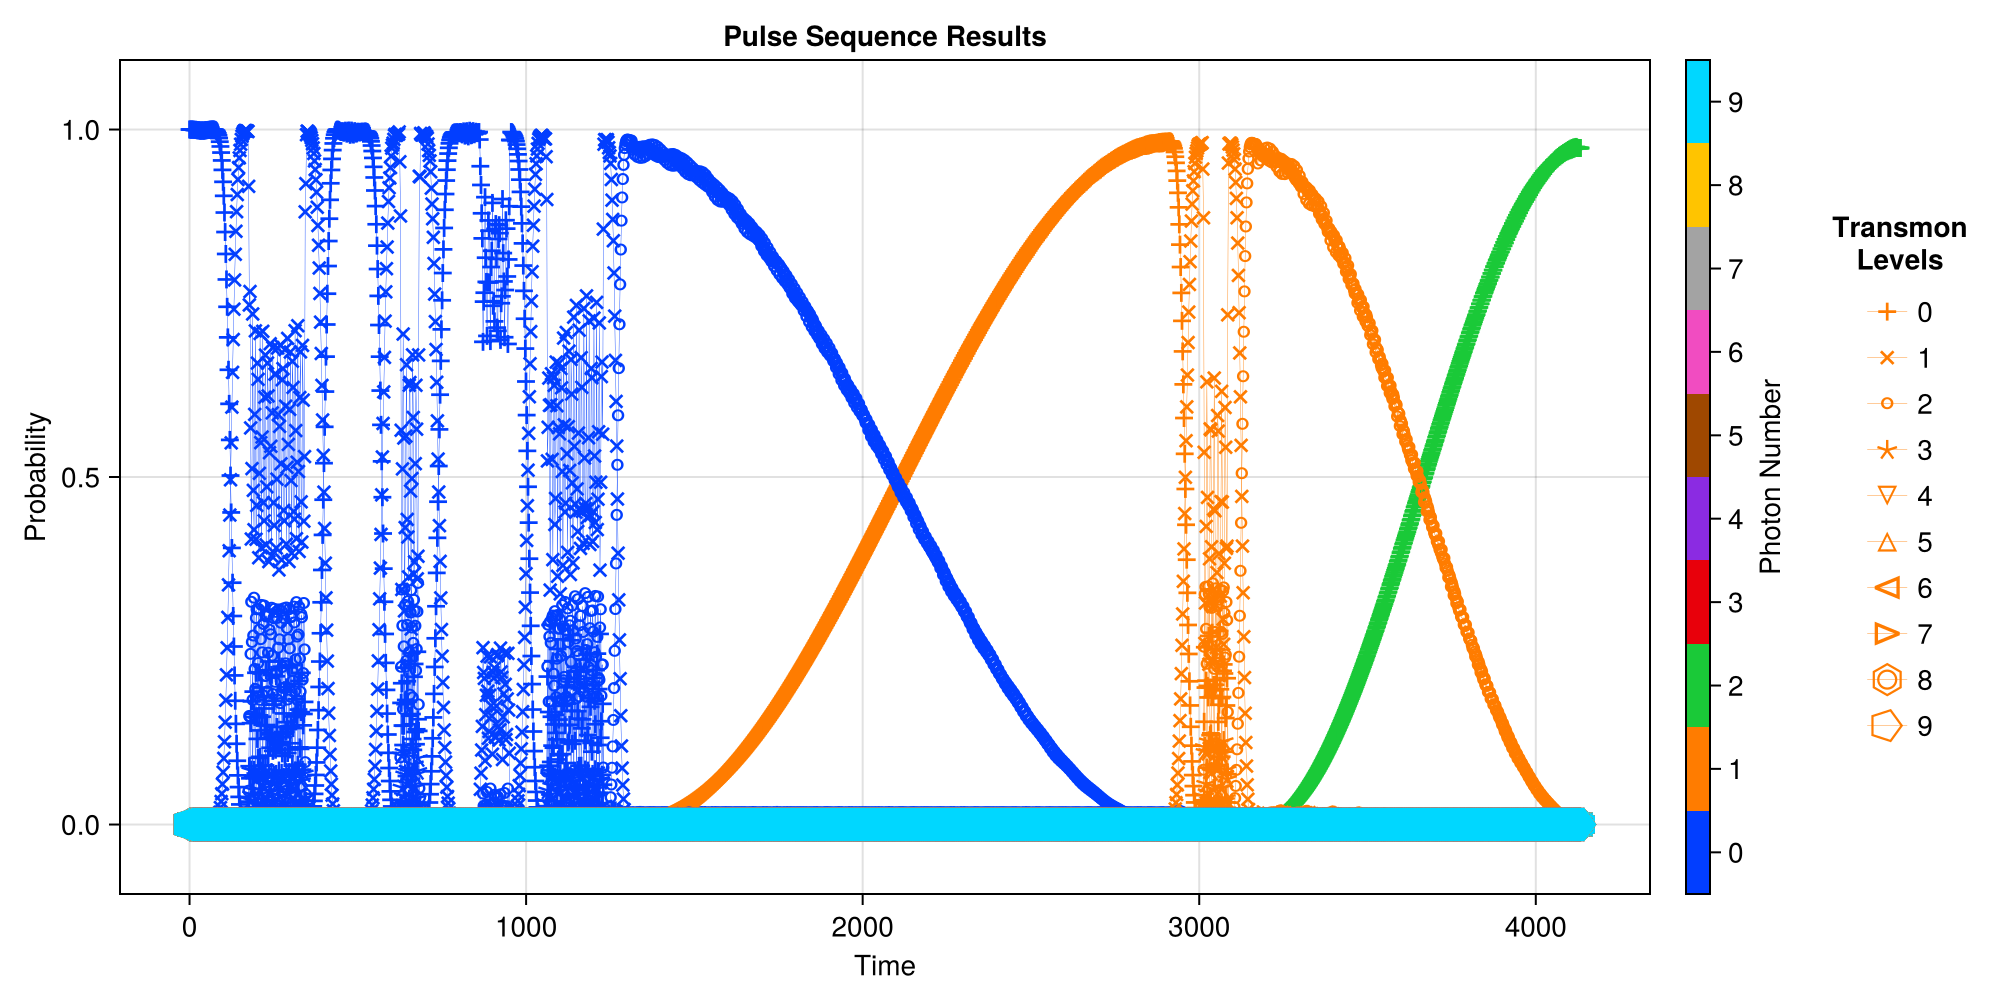

In [17]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, res["times"], EV_Dict, plot_every = 10)

## With Density Matrices

These runs take a long time. 

In [16]:
Mode3.CandD_Ops

Dict{Any, Any} with 3 entries:
  "Mode 3 Collapse"    => Quantum Object:   type=Operator   dims=[10, 10]   siz…
  "Transmon Collapse"  => Quantum Object:   type=Operator   dims=[10, 10]   siz…
  "Transmon Dephasing" => Quantum Object:   type=Operator   dims=[10, 10]   siz…

In [18]:
ψ = Mode3.dressed_states[(0,0)]
ρ = ψ*ψ'
SC.Dynamics.RunPulseSequence(Mode3, ρ, ["q_g_0"], c_ops = [], run_name = "Demo_Run_With_Out_Loss_"*string(now()))

The Name for this run is: Demo_Run_With_Out_Loss_2024-10-03T13:12:59.940
It is being saved at: Data/
[2024-10-03 13:13:00] Info: Step 1/1: Running operator q_g_0


UndefVarError: UndefVarError: `Get_Envelope` not defined

In [21]:
SC.Dynamics.RunPulseSequence(Mode3, ρ, Mode3.Stuff["Drive_Sequences"]["Binomial_Encoding"], c_ops = collect(values(Mode3.CandD_Ops)), run_name = "Demo_Run_With_Loss_"*string(now()))

The Name for this run is: Demo_Run_With_Loss_2024-10-03T13:13:28.383
It is being saved at: Data/
[2024-10-03 13:13:28] Info: Step 1/18: Running operator q_e_0


UndefVarError: UndefVarError: `Get_Envelope` not defined

## Searching For Pulses and Floquet Analysis

Lets look for a $|f0\rangle\to |g1\rangle$ sideband with $\epsilon = 0.8$ 

#### Getting Stark Shift

[2024-10-03 13:10:30] Info: Beginning Floquet Sweep
[2024-10-03 13:10:43] Info: Done With Floquet Sweep
[2024-10-03 13:10:44] Info: Tracking State "(2, 0)"
[2024-10-03 13:10:44] Info: Tracking State "(0, 1)"
[2024-10-03 13:10:46] Info: Fit Stuff: 3-element Vector{Float64}:	 0.04426662306182181	 0.0025599974098672023	 2.145891754743398


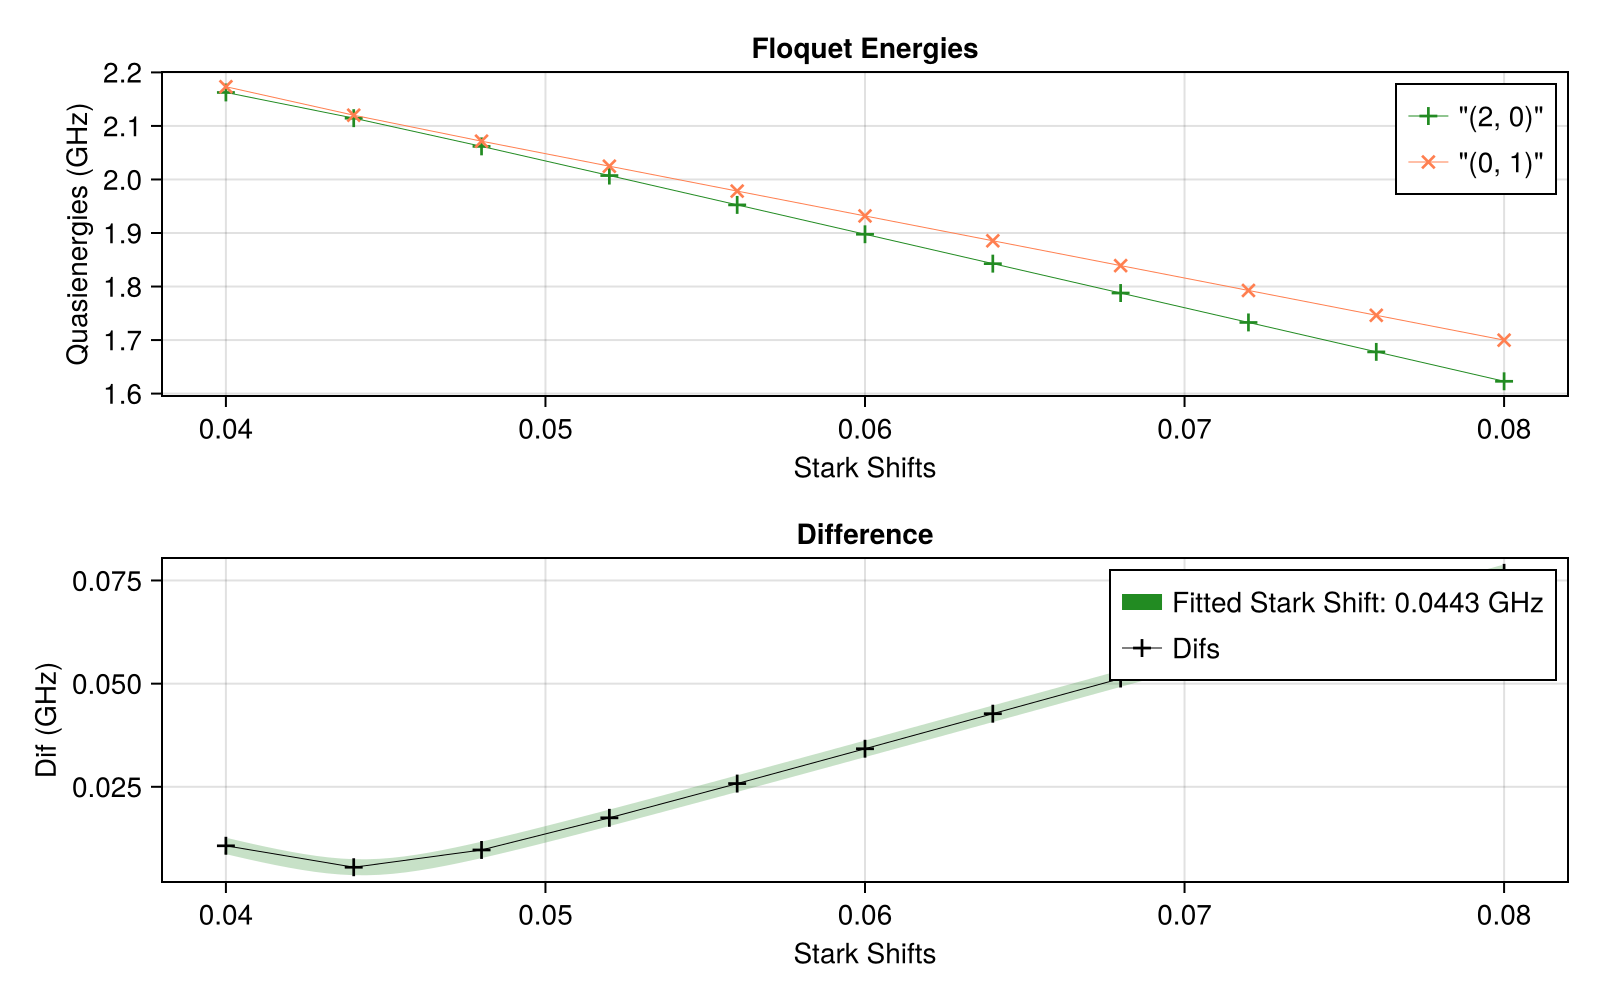

2-element Vector{Float64}:
   0.04426662306182181
 182.03406316271074

In [14]:
ε = 0.8

drive_op = Mode3.n̂ₜ;

state1 = (2,0);
state2 = (0,1);

stark_shift_list = collect(LinRange(0.04, 0.08, 11));

stark_shift_res = SC.Dynamics.FindStarkShift(Mode3, state1, state2, ε, stark_shift_list)

In [23]:
Mode3.dressed_energies[(0,0)]

-24.640780065303417

#### Getting Pulse Time!

In [15]:
ψ1 = Mode3.dressed_states[state1]
ψ2 = Mode3.dressed_states[state2]

freq_d = Mode3.dressed_energies[state2]-Mode3.dressed_energies[state1]
envelope = "Sine_Squared_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" => 10, "pulse_time" => 0)

t_range = [stark_shift_res[2], stark_shift_res[2]+20] # 20 is 2x ramp time

optimize_res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ε, freq_d, stark_shift_res[1], t_range, envelope, envelope_args)

[2024-10-03 13:11:41] Info: On Level 1
[2024-10-03 13:11:41] Info: On Step 1: t = 182.03406316271074
[2024-10-03 13:11:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 08s (ETA: 0h 00m 00s)
[2024-10-03 13:11:55] Info: Time Evolution Complete
[2024-10-03 13:11:55] Info: Done with Level_1_step_1
[2024-10-03 13:11:55] Info: Accurace: 0.9906495881292976
[2024-10-03 13:11:55] Info: ------------------------------------------------------------------------------
[2024-10-03 13:11:55] Info: On Step 2: t = 187.03406316271074
[2024-10-03 13:11:55] Info: Running Time Evolution
Progress: [========                      ]  28.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 07s)

InterruptException: InterruptException: